In [9]:
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import random
import os
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## For visualizing results
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

In [10]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="4"

In [3]:
def filterDataset(ann_path, classes):    
    # initialize COCO api for instance annotations
    annFile = ann_path
    coco = COCO(annFile)
    
    images = []
    if classes!=None:
        # iterate for each individual class in the list
        for className in classes:
            # get all images containing given categories
            catIds = coco.getCatIds(catNms=className)
            imgIds = coco.getImgIds(catIds=catIds)
            images += coco.loadImgs(imgIds)
    
    else:
        imgIds = coco.getImgIds()
        images = coco.loadImgs(imgIds)
    
    # Now, filter out the repeated images
    unique_images = []
    for i in range(len(images)):
        if images[i] not in unique_images:
            unique_images.append(images[i])
            
    random.shuffle(unique_images)
    dataset_size = len(unique_images)
    
    return unique_images, dataset_size, coco

In [4]:
train_ann_path = r"D:\Nirwan\MRCNN_TF2\data\mito_data\annotations\train.json"
val_ann_path = r"D:\Nirwan\MRCNN_TF2\data\mito_data\annotations\val.json"

In [5]:
def getClassName(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return None

def getImage(imageObj, img_folder, input_image_size):
    # Read and normalize an image
    train_img = io.imread(img_folder + '/' + imageObj['file_name'])/255.0
    # Resize
    #print(train_img.shape)
    train_img = cv2.resize(train_img, input_image_size)
    if (len(train_img.shape)==3 and train_img.shape[2]==3): # If it is a RGB 3 channel image
        return train_img
    else: # To handle a black and white image, increase dimensions to 3
        stacked_img = np.stack((train_img,)*3, axis=-1)
        return stacked_img
    
def getNormalMask(imageObj, classes, coco, catIds, input_image_size):
    annIds = coco.getAnnIds(imageObj['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    cats = coco.loadCats(catIds)
    train_mask = np.zeros(input_image_size)
    for a in range(len(anns)):
        className = getClassName(anns[a]['category_id'], cats)
        pixel_value = classes.index(className)+1
        new_mask = cv2.resize(coco.annToMask(anns[a])*pixel_value, input_image_size)
        train_mask = np.maximum(new_mask, train_mask)

    # Add extra dimension for parity with train_img size [X * X * 3]
    train_mask = train_mask.reshape(input_image_size[0], input_image_size[1], 1)
    return train_mask  
    
def getBinaryMask(imageObj, coco, catIds, input_image_size):
    annIds = coco.getAnnIds(imageObj['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    train_mask = np.zeros(input_image_size)
    for a in range(len(anns)):
        new_mask = cv2.resize(coco.annToMask(anns[a]), input_image_size)
        
        #Threshold because resizing may cause extraneous values
        new_mask[new_mask >= 0.5] = 1
        new_mask[new_mask < 0.5] = 0

        train_mask = np.maximum(new_mask, train_mask)

    # Add extra dimension for parity with train_img size [X * X * 3]
    train_mask = train_mask.reshape(input_image_size[0], input_image_size[1], 1)
    return train_mask


def dataGeneratorCoco(images, classes, coco, folder, 
                      input_image_size=(224,224), batch_size=4, mask_type='binary'):
    
    img_folder = '{}'.format(folder)
    dataset_size = len(images)
    catIds = coco.getCatIds(catNms=classes)
    
    c = 0
    while(True):
        img = np.zeros((batch_size, input_image_size[0], input_image_size[1], 3)).astype('float')
        mask = np.zeros((batch_size, input_image_size[0], input_image_size[1], 1)).astype('float')
        
        for i in range(c, c+batch_size): #initially from 0 to batch_size, when c = 0
            imageObj = images[i]
            
            ### Retrieve Image ###
            #print(imageObj)
            train_img = getImage(imageObj, img_folder, input_image_size)
            
            ### Create Mask ###
            if mask_type=="binary":
                train_mask = getBinaryMask(imageObj, coco, catIds, input_image_size)
            
            elif mask_type=="normal":
                train_mask = getNormalMask(imageObj, classes, coco, catIds, input_image_size)                
            
            # Add to respective batch sized arrays
            #print(train_mask.shape)
            img[i-c] = train_img
            mask[i-c] = train_mask
            
        c+=batch_size
        if(c + batch_size >= dataset_size):
            c=0
            random.shuffle(images)
        
        assert not np.any(np.isnan(img))
        assert not np.any(np.isnan(mask))
        
        yield img, mask/255

In [6]:
classes = ['mito_red', 'mito_green', 'mito_overlap']

In [7]:
train_images, train_dataset_size, train_coco = filterDataset(train_ann_path, classes,)
val_images, val_dataset_size, val_coco = filterDataset(val_ann_path, classes,)

loading annotations into memory...
Done (t=0.86s)
creating index...
index created!
loading annotations into memory...
Done (t=0.38s)
creating index...
index created!


In [8]:
batch_size = 4
input_image_size = (256,256)
mask_type = 'normal'

train_img_folder = r'D:\Nirwan\MRCNN_TF2\data\mito_data\rgb\train'
val_img_folder = r'D:\Nirwan\MRCNN_TF2\data\mito_data\rgb\val'

train_gen = dataGeneratorCoco(train_images, classes, train_coco, train_img_folder,
                            input_image_size, batch_size, mask_type)
val_gen = dataGeneratorCoco(val_images, classes, val_coco, val_img_folder,
                            input_image_size, batch_size, mask_type)

In [9]:
from PIL import Image
image = Image.open(r"D:\Nirwan\MRCNN_TF2\data\mito_data\rgb\train\0.png")
np.array(image).shape
image.mode

'RGB'

In [10]:
def visualizeGenerator(gen):
    img, mask = next(gen)
    
    fig = plt.figure(figsize=(20, 10))
    outerGrid = gridspec.GridSpec(1, 2, wspace=0.1, hspace=0.1)
    
    for i in range(2):
        innerGrid = gridspec.GridSpecFromSubplotSpec(2, 2,
                        subplot_spec=outerGrid[i], wspace=0.05, hspace=0.05)

        for j in range(4):
            ax = plt.Subplot(fig, innerGrid[j])
            if(i==1):
                ax.imshow(img[j])
            else:
                ax.imshow(mask[j][:,:,0])
                
            ax.axis('off')
            fig.add_subplot(ax)        
    plt.show()

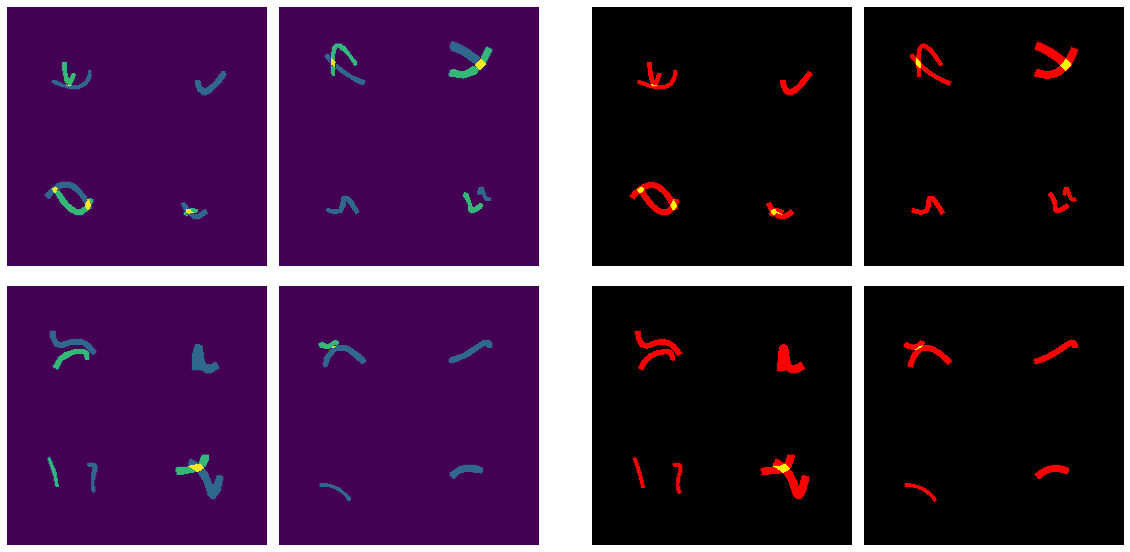

In [11]:
visualizeGenerator(train_gen)

In [3]:
n_epochs = 20
steps_per_epoch = train_dataset_size // batch_size
validation_steps = val_dataset_size // batch_size

NameError: name 'train_dataset_size' is not defined

In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [12]:
import segmentation_models as sm
from tensorflow import keras

Segmentation Models: using `keras` framework.


In [15]:
model = sm.Unet('efficientnetb7', classes=1, activation='sigmoid')

In [16]:
optim = keras.optimizers.Adam(0.0001)

In [17]:
dice_loss = sm.losses.DiceLoss(class_weights=np.ones(3)) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

In [18]:
model.compile(optim, total_loss, metrics)

In [19]:
checkpoint_dir = './training_checkpoints/mito'
        # Define the name of the checkpoint files.
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

In [20]:
callbacks = [
        tf.keras.callbacks.TensorBoard(log_dir='./semantic_logs'),
        tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix, verbose=0,
                                            save_weights_only=True),
        tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                            min_delta=0.001,
                                            patience=3,
                                            verbose=1,
                                            mode="auto",
                                            baseline=None,
                                            restore_best_weights=True),
    ]

In [21]:
history = model.fit(x=train_gen, validation_data=val_gen, epochs=20, steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps, verbose=True, callbacks=callbacks)

Epoch 1/20


KeyboardInterrupt: 

In [ ]:
plt.plot(history.history["loss"])
plt.title("Training Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["iou_score"])
plt.title("Training IOU score")
plt.ylabel("iou_score")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["f1-score"])
plt.title("Training F1 score")
plt.ylabel("F1 score")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_loss"])
plt.title("Validation Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_iou_score"])
plt.title("Validation IOU score")
plt.ylabel("iou_score")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_f1-score"])
plt.title("Validation F1 score")
plt.ylabel("F1 score")
plt.xlabel("epoch")
plt.show()

In [ ]:
model.save("mito_sem_seg_model.h5")

In [36]:
import glob

IMAGE_SIZE = 384
BATCH_SIZE = 4
NUM_CLASSES = 3
DATA_DIR = "./instance-level_human_parsing/instance-level_human_parsing/Training"
NUM_TRAIN_IMAGES = 1000
NUM_VAL_IMAGES = 50



train_images = []
train_masks = []
val_images = []
train_mask_check = []
val_mask_check = []
val_masks = []


    
for masks in os.listdir(r"D:\Nirwan\MRCNN_TF2\data\iSAID\train\Semantic_masks"):
    train_masks.append(os.path.join(r"D:\Nirwan\MRCNN_TF2\data\iSAID\train\Semantic_masks", masks))
    train_mask_check.append(masks)
    
for images in os.listdir(r"D:\Nirwan\MRCNN_TF2\data\iSAID\train\images"):
    #if images in train_mask_check:
    train_images.append(os.path.join(r"D:\Nirwan\MRCNN_TF2\data\iSAID\train\images", images))
    
    



    


In [37]:
for masks in os.listdir(r"D:\Nirwan\MRCNN_TF2\data\iSAID\val\Semantic_masks"):
    val_masks.append(os.path.join(r"D:\Nirwan\MRCNN_TF2\data\iSAID\val\Semantic_masks", masks))
    val_mask_check.append(masks)

for images in os.listdir(r"D:\Nirwan\MRCNN_TF2\data\iSAID\val\images"):
    #if images in val_mask_check:
    val_images.append(os.path.join(r"D:\Nirwan\MRCNN_TF2\data\iSAID\val\images", images))

In [38]:
len(val_masks)

458

In [39]:
def read_image(image_path, mask=False):
    image = tf.io.read_file(image_path)
    if mask:
        image = tf.image.decode_png(image, channels=1)
        image.set_shape([None, None, 1])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
    else:
        image = tf.image.decode_png(image, channels=3)
        image.set_shape([None, None, 3])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
        image = image / 127.5 - 1
    return image/255


def load_data(image_list, mask_list):
    image = read_image(image_list)
    mask = read_image(mask_list, mask=True)
    return image, mask


def data_generator(image_list, mask_list):
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    return dataset


train_dataset = data_generator(train_images, train_masks)
val_dataset = data_generator(val_images, val_masks)

print("Train Dataset:", train_dataset)
print("Val Dataset:", val_dataset)

Train Dataset: <BatchDataset element_spec=(TensorSpec(shape=(4, 384, 384, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4, 384, 384, 1), dtype=tf.float32, name=None))>
Val Dataset: <BatchDataset element_spec=(TensorSpec(shape=(4, 384, 384, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4, 384, 384, 1), dtype=tf.float32, name=None))>


In [40]:
model = sm.PSPNet('efficientnetb7', classes=16, activation='sigmoid')

In [41]:
optim = keras.optimizers.Adam(0.0001)
dice_loss = sm.losses.DiceLoss(class_weights=np.ones(16)) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

In [42]:
model.compile(optim, total_loss, metrics)

In [43]:
checkpoint_dir = './training_checkpoints/isaid'
        # Define the name of the checkpoint files.
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

In [44]:
callbacks = [
        keras.callbacks.TensorBoard(log_dir='./semantic_logs'),
        keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix, verbose=0,
                                            save_weights_only=True),
        keras.callbacks.EarlyStopping(monitor="val_loss",
                                            min_delta=0.001,
                                            patience=3,
                                            verbose=1,
                                            mode="auto",
                                            baseline=None,
                                            restore_best_weights=True),
    ]

In [45]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=total_loss,
    metrics=metrics,
)

history = model.fit(train_dataset, validation_data=val_dataset, epochs=20, callbacks=callbacks)

Epoch 1/20
352/352 [==============================] - 147s 373ms/step - loss: 0.8971 - iou_score: 0.0688 - f1-score: 0.1234 - val_loss: 1.0328 - val_iou_score: 1.1119e-04 - val_f1-score: 2.1837e-04
Epoch 2/20
352/352 [==============================] - 135s 372ms/step - loss: 0.8528 - iou_score: 0.0956 - f1-score: 0.1679 - val_loss: 0.8973 - val_iou_score: 0.0704 - val_f1-score: 0.1267
Epoch 3/20
352/352 [==============================] - 134s 370ms/step - loss: 0.8403 - iou_score: 0.1042 - f1-score: 0.1817 - val_loss: 0.9233 - val_iou_score: 0.0531 - val_f1-score: 0.0985
Epoch 4/20
352/352 [==============================] - 134s 370ms/step - loss: 0.8318 - iou_score: 0.1099 - f1-score: 0.1907 - val_loss: 0.9154 - val_iou_score: 0.0604 - val_f1-score: 0.1113
Epoch 5/20
352/352 [==============================] - 135s 374ms/step - loss: 0.8186 - iou_score: 0.1184 - f1-score: 0.2042 - val_loss: 0.9242 - val_iou_score: 0.0654 - val_f1-score: 0.1162
Epoch 5: early stopping


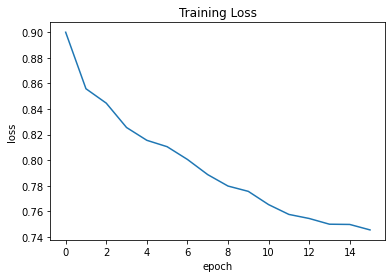

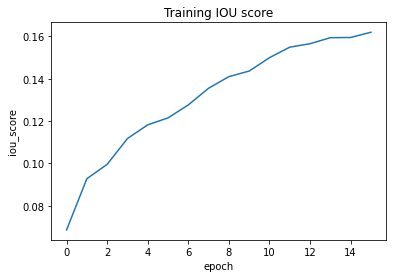

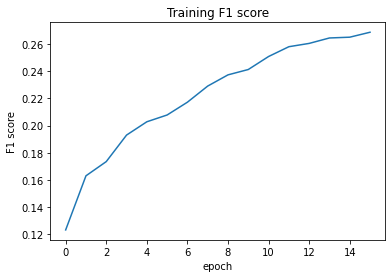

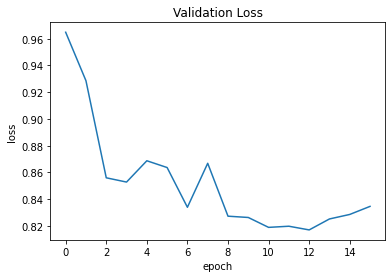

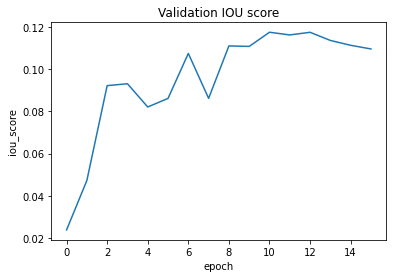

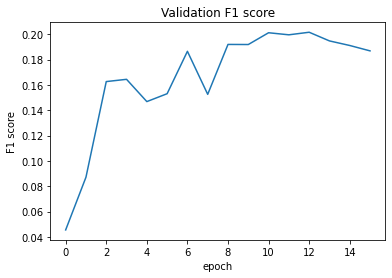

In [28]:
plt.plot(history.history["loss"])
plt.title("Training Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["iou_score"])
plt.title("Training IOU score")
plt.ylabel("iou_score")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["f1-score"])
plt.title("Training F1 score")
plt.ylabel("F1 score")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_loss"])
plt.title("Validation Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_iou_score"])
plt.title("Validation IOU score")
plt.ylabel("iou_score")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_f1-score"])
plt.title("Validation F1 score")
plt.ylabel("F1 score")
plt.xlabel("epoch")
plt.show()

In [29]:
model.save("isaid_sem_seg_model.h5")

In [39]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 stem_conv (Conv2D)             (None, None, None,   1728        ['input_3[0][0]']                
                                64)                                                               
                                                                                                  
 stem_bn (BatchNormalization)   (None, None, None,   256         ['stem_conv[0][0]']              
                                64)                                                         

In [40]:
a = tf.zeros([2, 2])
b = tf.ones([2, 2])
max = tf.keras.layers.Maximum()([a, b])
max

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[1., 1.],
       [1., 1.]], dtype=float32)>

In [46]:
import segmentation_models as sm
from tensorflow import keras

In [47]:
model = sm.Unet('efficientnetb7', classes=80, activation='sigmoid')

In [51]:
checkpoint_dir = './training_checkpoints/coco/ckpt_23'

In [52]:
model.load_weights(checkpoint_dir)

In [64]:
model.save("coco_semseg_model.h5")

In [58]:
image = cv2.imread("test.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Perform a forward pass of the network to obtain the results
image.shape

(291, 445, 3)

In [63]:
import numpy as np
image = cv2.resize(image, [256, 256])
image = np.reshape(image, (1, 291, 445, 3))

ValueError: cannot reshape array of size 196608 into shape (1,291,445,3)

In [60]:
r = model.predict(image)

ValueError: in user code:

    File "c:\Users\nba055\.conda\envs\tensorflow3\lib\site-packages\keras\engine\training.py", line 1845, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\nba055\.conda\envs\tensorflow3\lib\site-packages\keras\engine\training.py", line 1834, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\nba055\.conda\envs\tensorflow3\lib\site-packages\keras\engine\training.py", line 1823, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\nba055\.conda\envs\tensorflow3\lib\site-packages\keras\engine\training.py", line 1791, in predict_step
        return self(x, training=False)
    File "c:\Users\nba055\.conda\envs\tensorflow3\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\nba055\.conda\envs\tensorflow3\lib\site-packages\keras\backend.py", line 3313, in concatenate
        return tf.concat([to_dense(x) for x in tensors], axis)

    ValueError: Exception encountered when calling layer "decoder_stage0_concat" (type Concatenate).
    
    Dimension 1 in both shapes must be equal, but are 20 and 19. Shapes are [?,20,28] and [?,19,28]. for '{{node model_3/decoder_stage0_concat/concat}} = ConcatV2[N=2, T=DT_FLOAT, Tidx=DT_INT32](model_3/decoder_stage0_upsampling/resize/ResizeNearestNeighbor, model_3/block6a_expand_activation/IdentityN, model_3/decoder_stage0_concat/concat/axis)' with input shapes: [?,20,28,2560], [?,19,28,1344], [] and with computed input tensors: input[2] = <3>.
    
    Call arguments received by layer "decoder_stage0_concat" (type Concatenate):
      • inputs=['tf.Tensor(shape=(None, 20, 28, 2560), dtype=float32)', 'tf.Tensor(shape=(None, 19, 28, 1344), dtype=float32)']
